In [1]:
import os
from glob import glob
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import obspy
from obspy.core import UTCDateTime
from obspy.signal.filter import envelope
from obspy.signal.invsim import paz_to_freq_resp

import changefinder

In [2]:
# 可視化用関数
def vis(arr, color=None, figsize=(24, 4), ylim=(None, None)):
    plt.figure(figsize=figsize)
    plt.plot(arr, color=color)
    plt.ylim(ylim[0], ylim[1])
    plt.show()

# クラス・メソッドの定義

In [3]:
class MQ_Analysis:
    '''
    月震の解析用クラス
    
    Attributes:
        station (Int): ステーション番号
        data_lpx (Stream): LP-X DATA
        data_lpy (Stream): LP-Y DATA
        data_lpz (Stream): LP-Z DATA
        data_spz (Stream): SP-Z DATA
        data_lpx_du (Stream): LP-X DU DATA
        data_lpy_du (Stream): LP-Y DU DATA
        data_lpz_du (Stream): LP-Z DU DATA
        data_spz_du (Stream): SP-Z DU DATA
    '''
    def __init__(self, station):
        '''
        Initialization
        
        Args:
            input_station: ステーション番号
        '''
        self.station = station
        self.data_lpx = None
        self.data_lpy = None
        self.data_lpz = None
        self.data_spz = None
        self.data_lpx_du = None
        self.data_lpy_du = None
        self.data_lpz_du = None
        self.data_spz_du = None
        
        
    def download(self, url):
        '''
        データのダウンロード (obspyプラグインが必要)
        
        Args:
            url (Str): ダウンロードURL
        '''
        # 末尾の数字に1を足す
        url2 = url.split('.')
        url2[-1] = str(int(url.split('.')[-1]) + 1)
        url2 = '.'.join(url2)

        # ダウンロード
        data = obspy.read(url)
        data += obspy.read(url2)
        
        # メンバ変数に格納 (selectが空集合の場合はNoneが入る)
        self.data_lpx = data.select(id='XA.S{}..LPX'.format(self.station))
        self.data_lpy = data.select(id='XA.S{}..LPY'.format(self.station))
        self.data_lpz = data.select(id='XA.S{}..LPZ'.format(self.station))
        self.data_spz = data.select(id='XA.S{}..SPZ'.format(self.station))
        
        # 複数データがあるものをmergeする
        if self.data_lpx != None: self.data_lpx.merge(method=1, fill_value='interpolate')
        if self.data_lpy != None: self.data_lpy.merge(method=1, fill_value='interpolate')
        if self.data_lpz != None: self.data_lpz.merge(method=1, fill_value='interpolate')
        if self.data_spz != None: self.data_spz.merge(method=1, fill_value='interpolate')
        
        
    def read_sac(self, path, verbose=0):
        '''
        SACファイルを読み込む
        
        Args:
            path (Str): SACファイルが入ったディレクトリのパス
        '''
        files = glob(path + '/SMQ_*.sac')
        if verbose >= 1:
            print(files)
        
        # メンバ変数に格納
        file = path + '/SMQ_LPX.sac'
        if file in files: self.data_lpx = obspy.read(file)
        
        file = path + '/SMQ_LPY.sac'
        if file in files: self.data_lpy = obspy.read(file)
        
        file = path + '/SMQ_LPZ.sac'
        if file in files: self.data_lpz = obspy.read(file)
        
        file = path + '/SMQ_SPZ.sac'
        if file in files: self.data_spz = obspy.read(file)
    
    
    def to_sac(self, path):
        '''
        SACファイルに出力
        
        Args:
            path (Str): SACファイルの出力先のパス
        '''
        # ステーション番号のディレクトリを作成
        dir_path = path + '/S' + str(self.station)
        os.mkdir(dir_path)
        
        # SACファイルの出力
        if self.data_lpx != None:
            self.data_lpx.write(dir_path + '/SMQ_LPX.sac', format='SAC')
        if self.data_lpy != None:
            self.data_lpy.write(dir_path + '/SMQ_LPY.sac', format='SAC')
        if self.data_lpz != None:
            self.data_lpz.write(dir_path + '/SMQ_LPZ.sac', format='SAC')
        if self.data_spz != None:
            self.data_spz.write(dir_path + '/SMQ_SPZ.sac', format='SAC')
        
    
    def remove_noise(
        self,
        channel,
        span = 1000,
        threshold = 3.0,
        times = 5,
        verbose = 0
    ):
        '''
        ノイズを除去する
        
        Args:
            channel (Str): ノイズ除去を行うデータのチャンネル -> {'ALL', 'LPX', 'LPY', 'LPZ', 'SPZ'}
            span (Int): ウィンドウサイズ
            threshold (Float): 閾値
            times (Int): ノイズ除去処理のループ回数
            verbose (Int): 0:何も表示しない, 1:ノイズ除去前後のグラフ比較
        '''
        if channel == 'ALL':
            # ALLオプションで全チャンネルに対して前処理を行う
            channels = ['LPX', 'LPY', 'LPZ', 'SPZ']
        else:
            channels = [channel]
            
        for ch in channels:
            # メンバ変数をコピー
            if ch == 'LPX': data = self.data_lpx
            elif ch == 'LPY': data = self.data_lpy
            elif ch == 'LPZ': data = self.data_lpz
            elif ch == 'SPZ': data = self.data_spz
            else: assert False
                
            if verbose >= 1:
                starttime = data[0].stats.starttime
                endtime = data[0].stats.endtime
                
            # 型変換 (Ndarray -> Series)
            data = pd.Series(data[0].data)
                
            if verbose >= 1:
                # ノイズ除去前のグラフを描画
                plt.figure(figsize=(24, 8))
                plt.title('{} ({} - {})'.format(ch, starttime, endtime))
                plt.plot(data.index, data, label='pre', color='blue')
                
                # 1周目のみノイズを描画するためのフラグ
                flag_visualizing = True
                
            # ノイズの除去
            for _ in [0]*times: # times回ループ
                ewm_mean = data.ewm(span=span).mean()  # 指数加重移動平均
                ewm_std = data.ewm(span=span).std()  # 指数加重移動標準偏差
                noise = data[(data - ewm_mean).abs() > ewm_std * threshold]
                
                if verbose >= 1 and flag_visualizing:
                    # 閾値やノイズの描画 (1周目のみ描画)
                    plt.fill_between(
                        data.index,
                        ewm_mean - ewm_std * threshold,
                        ewm_mean + ewm_std * threshold,
                        alpha=0.2,
                        color='cyan'
                    )
                    plt.scatter(noise.index, noise, label='noise', color='red')
                    flag_visualizing = False
                
                data[noise.index] = ewm_mean[noise.index]
                
            # 型変換 (Ndarray -> Series)
            data = np.array(data)
            
            if verbose >= 1:
                # ノイズ除去後のグラフを描画
                plt.plot(data, label='post', color='lime')
                plt.legend()
                plt.show()
                
        # メンバ変数にノイズ除去後のデータを戻す
        if ch == 'LPX': self.data_lpx[0].data = data
        elif ch == 'LPY': self.data_lpy[0].data = data
        elif ch == 'LPZ': self.data_lpz[0].data = data
        elif ch == 'SPZ': self.data_spz[0].data = data
        
        
    def data_preprocessing(
        self,
        channel,
        pre_high_freq,
        pre_low_freq,
        post_high_freq,
        post_low_freq,
        paz_remove
    ):
        '''
        前処理

        Args:
            data (Stream): ObspyのStreamオブジェクトに格納されたデータ
            channel (Str): 前処理を行うデータのチャンネル -> {'ALL', 'LPX', 'LPY', 'LPZ', 'SPZ'}
            pre_high_freq (Float): Pre-Filtering (Low-Pass) の閾値
            pre_low_freq (Float): Pre-Filtering (High-Pass) の閾値
            post_high_freq (Float): Filtering (Low-Pass) の閾値
            post_low_freq (Float): Filtering (High-Pass) の閾値
            paz_remove (Dict): "poles", "zeros", "gain", "sensitivity"を含むデータ

        Returns:
            data_PSD (Ndarray): dataのPSD
        '''
        if channel == 'ALL':
            # ALLオプションで全チャンネルに対して前処理を行う
            channels = ['LPX', 'LPY', 'LPZ', 'SPZ']
        else:
            channels = [channel]
            
        for ch in channels:
            # メンバ変数をコピー
            if ch == 'LPX': data = self.data_lpx
            elif ch == 'LPY': data = self.data_lpy
            elif ch == 'LPZ': data = self.data_lpz
            elif ch == 'SPZ': data = self.data_spz
            else: assert False
            
            # 前処理
            data.detrend(type='linear') # detrend
            data.detrend('demean') # demean
            data.taper(0.05, type='cosine')
            data.filter('lowpass', freq=pre_high_freq, zerophase=True)
            data.filter('highpass', freq=pre_low_freq, zerophase=True)
            data.simulate(paz_remove=paz_remove) # Remove response
            data.taper(0.05, type='cosine')
            data.differentiate(method='gradient')
            
            # DU値をメンバ変数に格納
            if ch == 'LPX': self.data_lpx_du = self.data_lpx
            elif ch == 'LPY': self.data_lpy_du = self.data_lpy
            elif ch == 'LPZ': self.data_lpz_du = self.data_lpz
            elif ch == 'SPZ': self.data_spz_du = self.data_spz
                
            data_PSD = data[0].data
            data.filter('lowpass', freq=freq_high, zerophase=True)
            data.filter('highpass', freq=freq_low, zerophase=True)
            
            # メンバ変数に前処理後のデータを戻す
            if ch == 'LPX': self.data_lpx = data
            elif ch == 'LPY': self.data_lpy = data
            elif ch == 'LPZ': self.data_lpz = data
            elif ch == 'SPZ': self.data_spz = data


# TEST

In [4]:
import time

In [30]:
smq = MQ_Analysis(15)
smq.read_sac('./dataset/SMQ_1day/710417/1day')

In [31]:
smq.data_spz

1 Trace(s) in Stream:
XA.S14..SPZ | 1971-04-17T00:00:00.013132Z - 1971-04-17T23:59:59.994264Z | 53.0 Hz, 4579200 samples

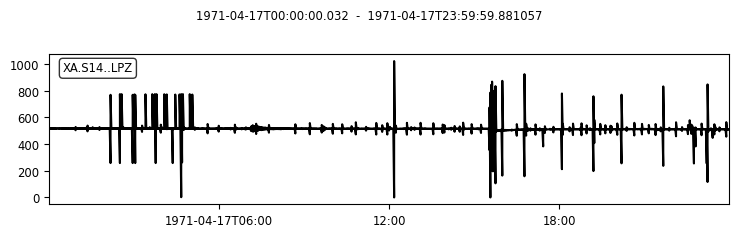

Execution time = 0.12207603454589844 s


In [32]:
start = time.time()
smq.data_lpz.plot()
print('Execution time = {} s'.format(time.time() - start))

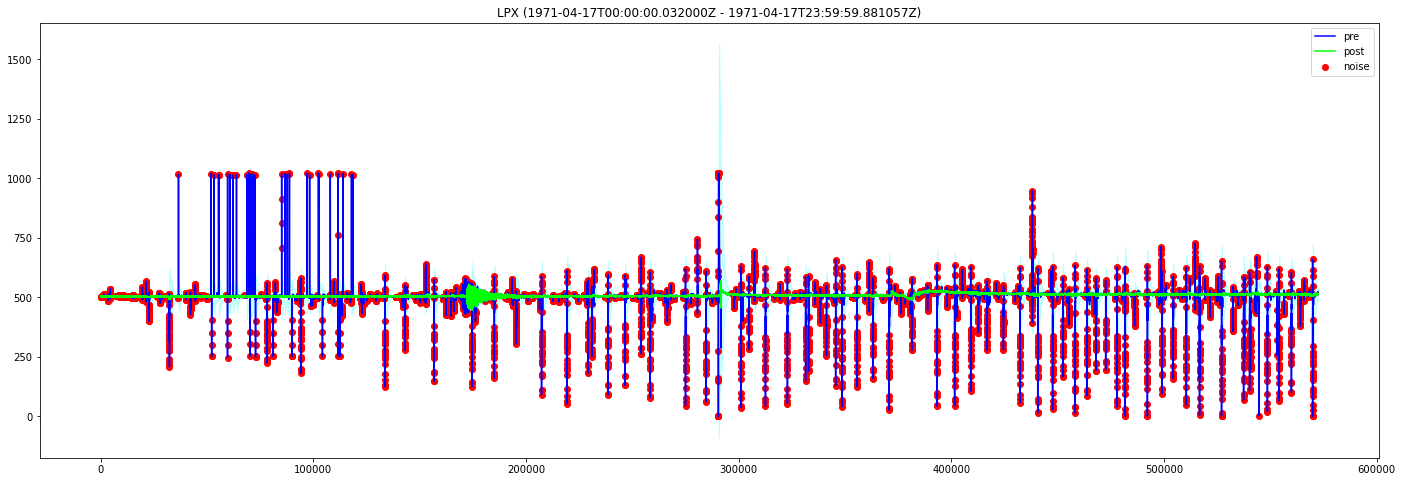

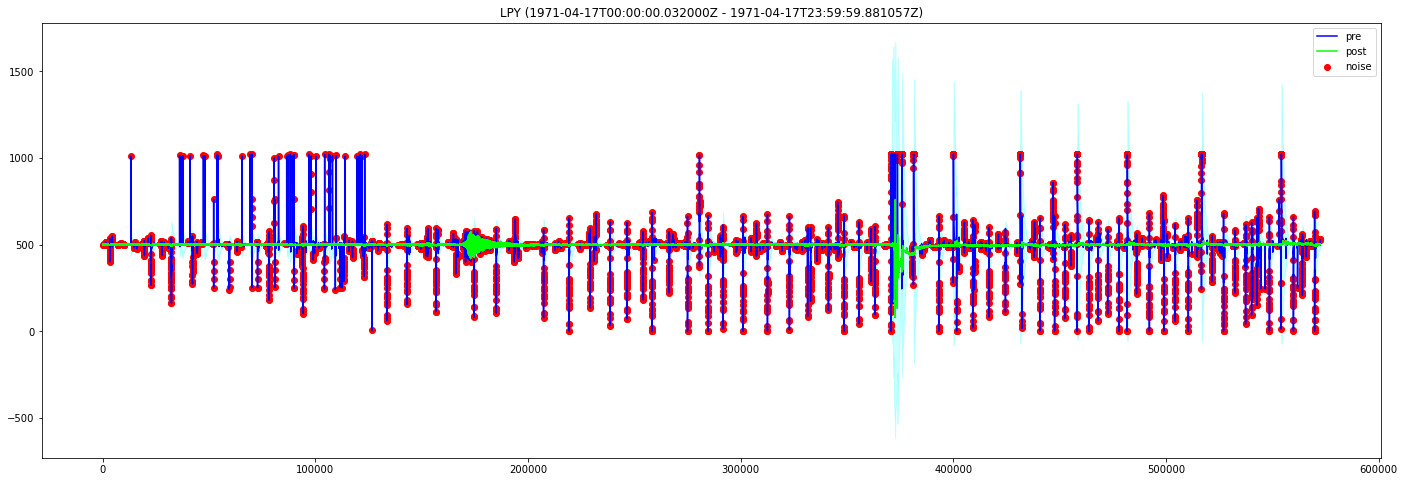

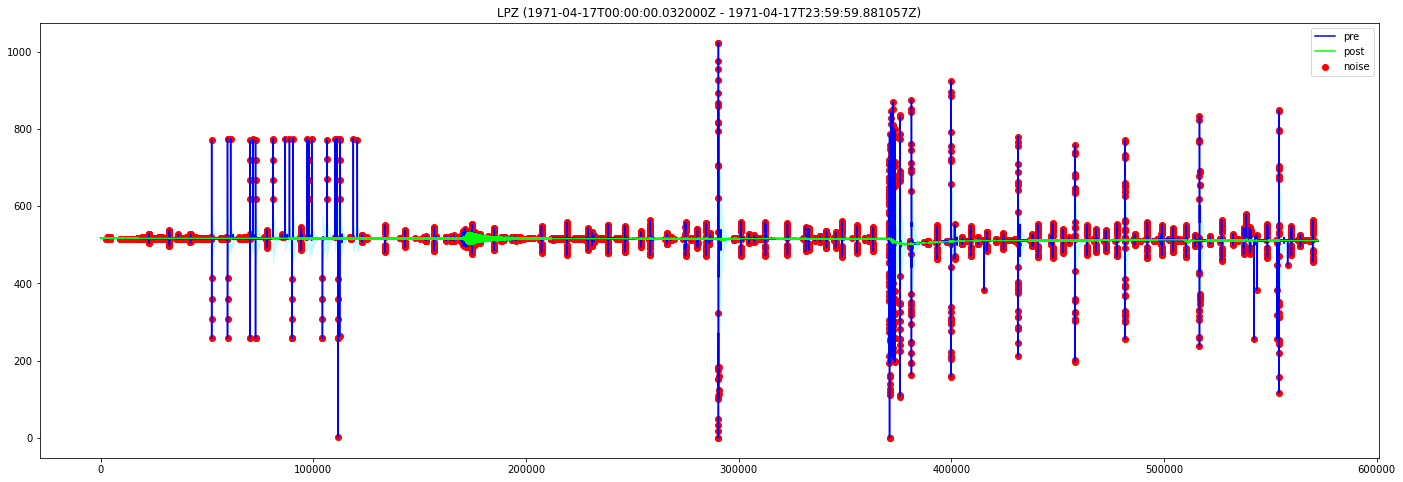

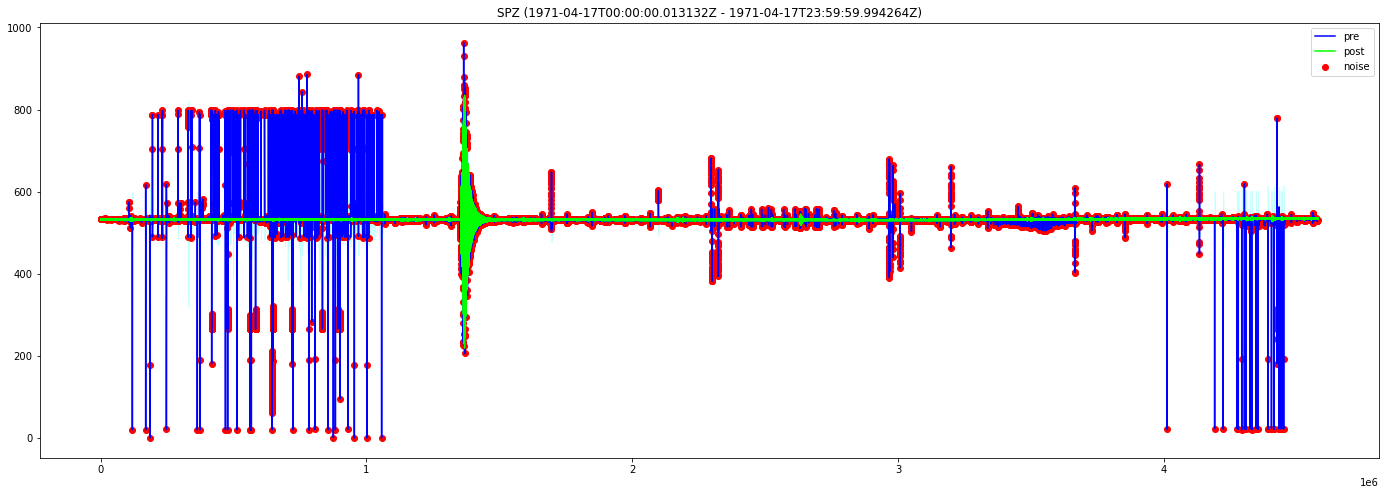

In [33]:
smq.remove_noise(
    channel = 'ALL',
    span = 1000,
    threshold = 3.0,
    times = 20,
    verbose = 1
)

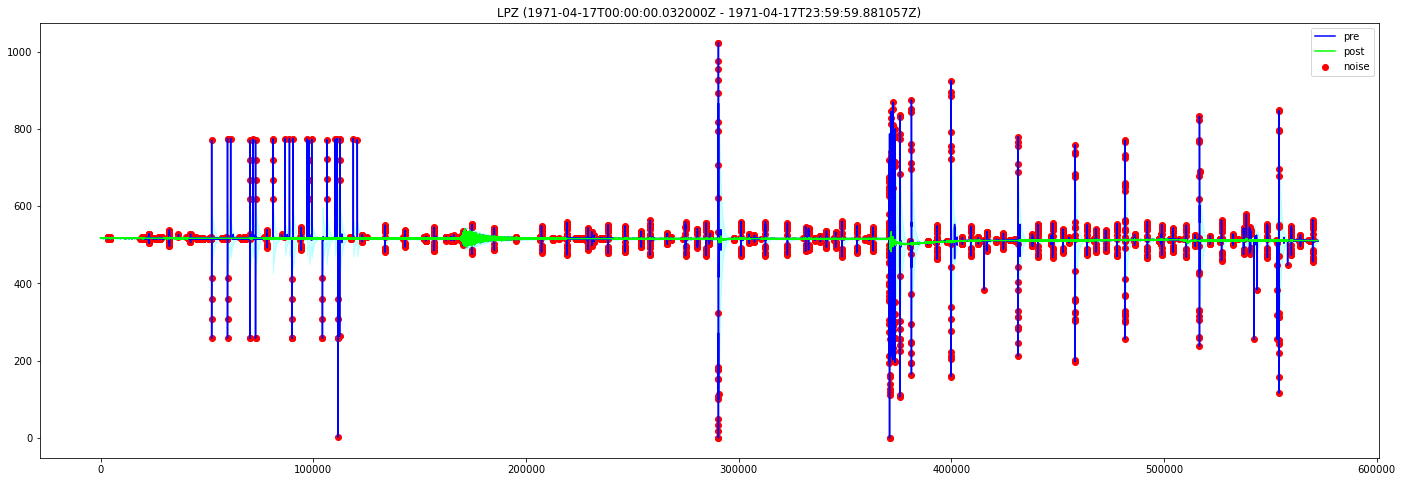

In [27]:
# channels = ['LPX', 'LPY', 'LPZ']
# for channel in channels:

# smq.remove_noise(
#     channel = 'ALL',
#     span = 1000,
#     threshold = 4.0,
#     times = 10,
#     verbose = 1
# )

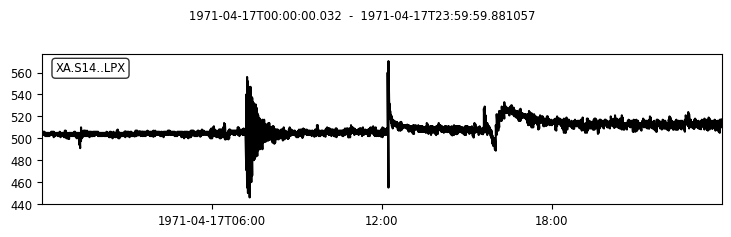

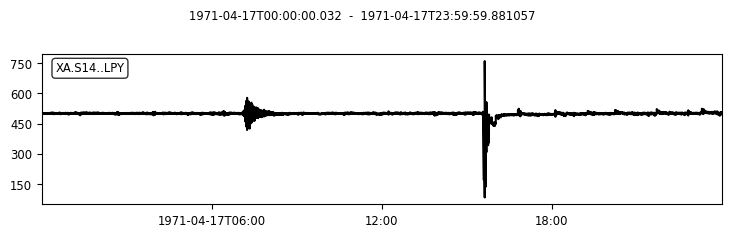

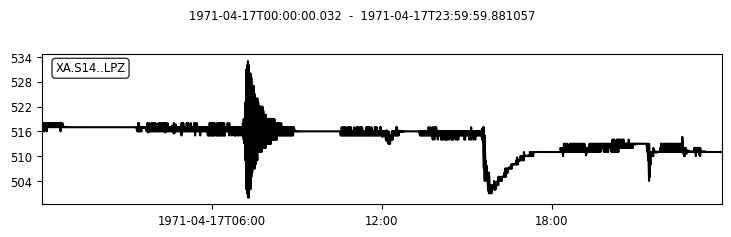

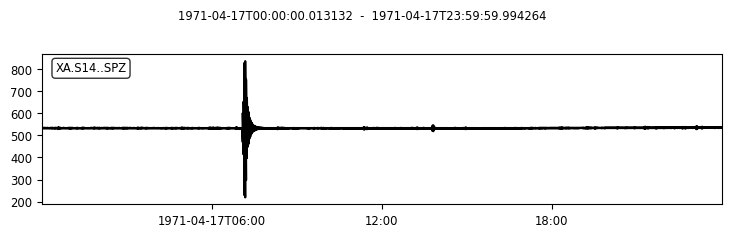

In [34]:
smq.data_lpx.plot()
smq.data_lpy.plot()
smq.data_lpz.plot()
smq.data_spz.plot()
plt.show()

# changefinderを用いた変化点検出

In [35]:
# 実行時間が長すぎる
cf = changefinder.ChangeFinder(r=0.01, order=1, smooth=10000)

ret = []
for i in smq.data_spz[0].data:
    score = cf.update(i)
    ret.append(score)

# 可視化
vis(smq.data_lpx[0].data,'r')
vis(ret)

KeyboardInterrupt: 

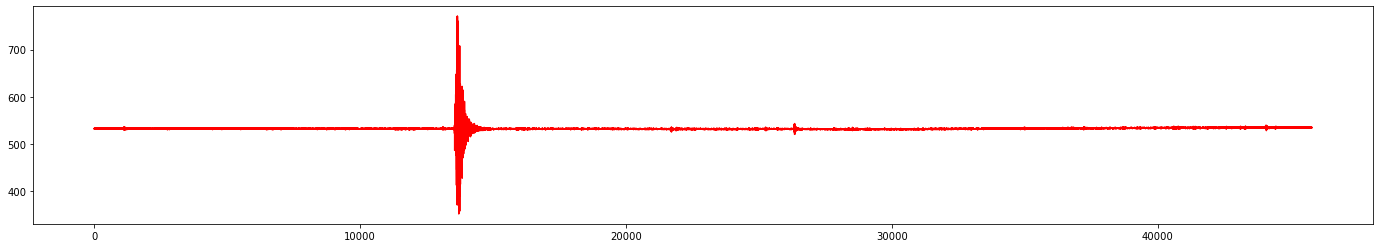

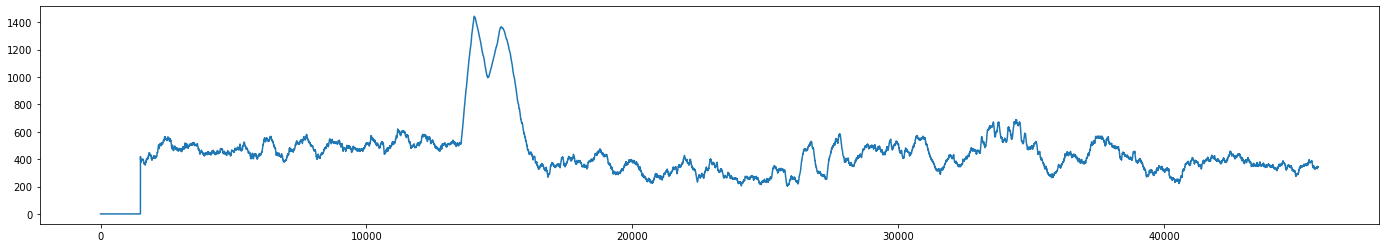

In [50]:
cf = changefinder.ChangeFinder(r=0.5, order=1, smooth=1000)

ret = []
for i in smq.data_spz[0].data[::100]:
    score = cf.update(i)
    ret.append(score)

# 可視化
vis(smq.data_spz[0].data[::100],'r')
vis(ret)

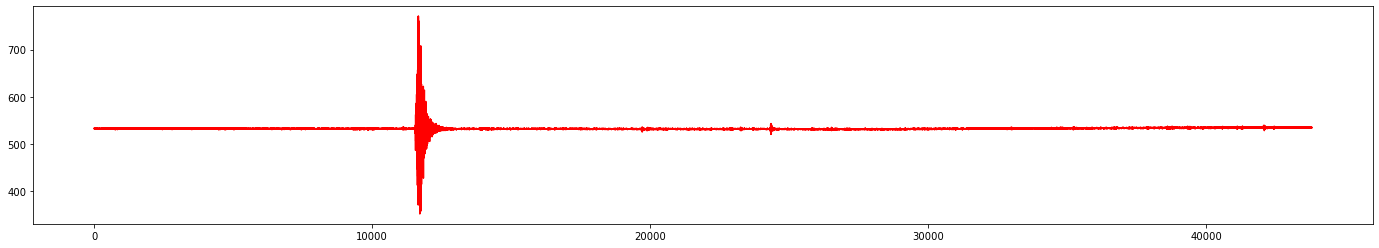

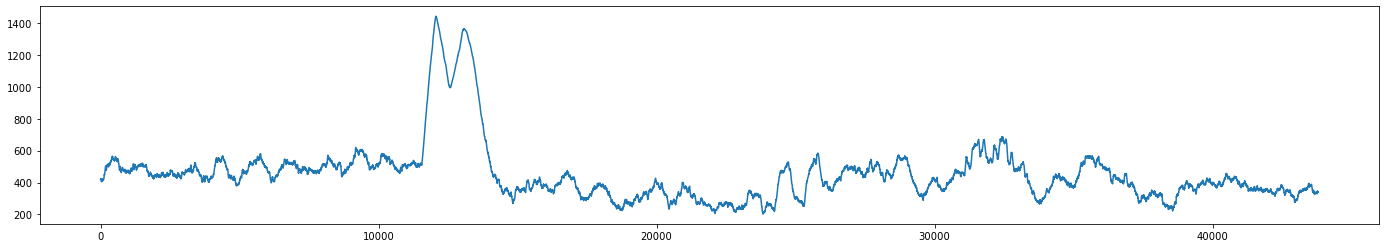

In [51]:
vis(smq.data_spz[0].data[::100][2000:],'r')
vis(ret[2000:])

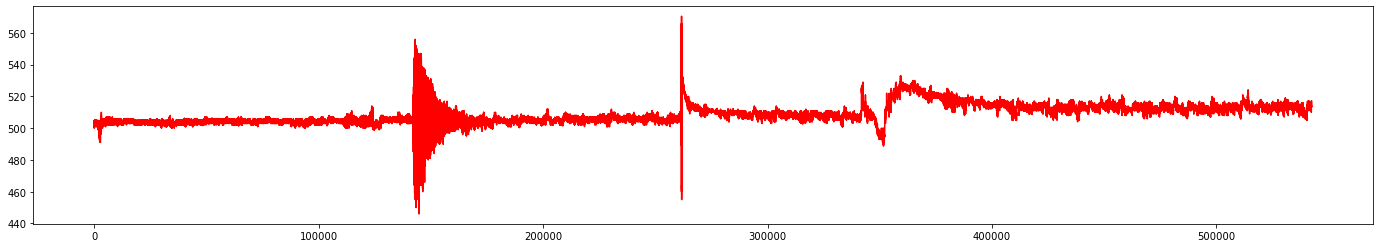

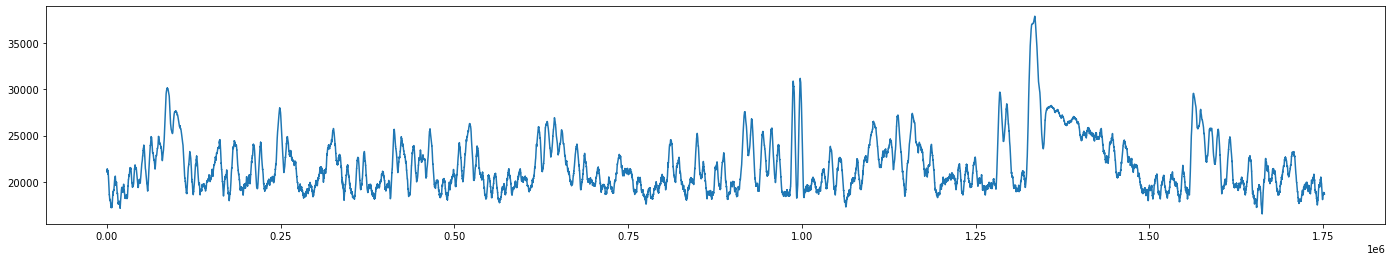

In [36]:
# 可視化
vis(smq.data_spz[0].data[:],'r')
vis(ret[30000:])

# 窓中央値

In [ ]:
# lpx
vis(smq.data_lpx[0].data, figsize=(24, 4))
vis(pd.Series(smq.data_lpx[0].data).rolling(1000).median(), 'r', ylim=(400, 600))

In [ ]:
# lpy
vis(smq.data_lpy[0].data, figsize=(24, 4))
vis(pd.Series(smq.data_lpy[0].data).rolling(1000).median(), 'r', ylim=(400, 600))

In [ ]:
# lpz
vis(smq.data_lpz[0].data, figsize=(24, 4))
vis(pd.Series(smq.data_lpz[0].data).rolling(1000).median(), 'r', ylim=(400, 500))

# 窓分散

In [ ]:
vis(smq.data_lpx[0].data)
vis(pd.Series(smq.data_lpx[0].data).rolling(1000).var(), 'r', ylim=(-100, 400))

In [ ]:
vis(smq.data_lpy[0].data)
vis(pd.Series(smq.data_lpy[0].data).rolling(1000).var(), 'r', ylim=(-100, 400))

In [ ]:
vis(smq.data_lpz[0].data)
vis(pd.Series(smq.data_lpz[0].data).rolling(1000).var(), 'r', ylim=(-100, 400))

# 窓平均

In [ ]:
vis(smq.data_lpx[0].data)
vis(pd.Series(smq.data_lpx[0].data).rolling(1000).mean(), 'r', ylim=(450, 550))

# SPのデータ全て描画

In [ ]:
files = [ # コメントアウトの部分はデータがない (？) 部分です．
    'dataset/SMQ_710417/S14',
    'dataset/SMQ_710520/S14',
    'dataset/SMQ_710711/S14',
    'dataset/SMQ_720102/S14',
    'dataset/SMQ_730208/S14',
#     'dataset/SMQ_730313/S14',
    'dataset/SMQ_730620/S14',
    'dataset/SMQ_731001/S14',
    'dataset/SMQ_740223/S14',
    'dataset/SMQ_740327/S14',
    'dataset/SMQ_740419/S14',
    'dataset/SMQ_740529/S14',
    'dataset/SMQ_740711/S14',
    'dataset/SMQ_750103/S14',
    'dataset/SMQ_750112/S14',
#     'dataset/SMQ_750113/S14',
#     'dataset/SMQ_750213/S14',
#     'dataset/SMQ_750507/S14',
#     'dataset/SMQ_750527/S14',
#     'dataset/SMQ_751110/S14',
#     'dataset/SMQ_760104/S14',
#     'dataset/SMQ_760112/S14',
#     'dataset/SMQ_760306/S14',
#     'dataset/SMQ_760308/S14',
#     'dataset/SMQ_760516/S14',
]

for file in files:
    smq = MQ_Analysis(14)
    smq.read_sac(file)
    smq.data_spz.plot()
    plt.show()

# TODO
- 変化点検出
- 分散の描画
- 切り抜きなしのデータダウンロード
- 描画の関数
- paz_to_freq_respの引数の説明をみる
- SMQ_710417 1日分のデータ 解析
- 異常値検出と変化点検出のスライドまとめ

In [ ]:
smq = MQ_Analysis(15)
smq.read_sac('dataset/SMQ_710520/S14')

In [ ]:
smq.data_lpx

In [ ]:
smq.data_lpz.plot()
plt.show()
smq.data_spz.plot()
plt.show()

In [ ]:
# SMQ_750103　綺麗